In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.decomposition import PCA

!pip install umap-learn
import umap

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans,DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


import time

In [4]:

df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/scaler_clustering.csv')

In [5]:
print(df.head(30))
print(df.shape)

    Unnamed: 0                         company_hash  \
0            0                       atrgxnnt xzaxv   
1            1            qtrxvzwt xzegwgbb rxbxnta   
2            2                        ojzwnvwnxw vx   
3            3                            ngpgutaxv   
4            4                           qxen sqghu   
5            5  yvuuxrj hzbvqqxta bvqptnxzs ucn rna   
6            6                   lubgqsvz wyvot  wg   
7            7                 vwwtznhqt ntwyzgrgsj   
8            8                   utqoxontzn ojontbo   
9            9                                xrbhd   
10          10                      ztfstz ogenfvqt   
11          11                           ngdor ntwy   
12          12           mvqwrvjo wgqugqvnt mvzpxzs   
13          13                            wgszxkvzn   
14          14                               xznhxn   
15          15                               bgsrxd   
16          16                    pnw xzaxv ucn rna   
17        

In [6]:
df.rename(columns={'Unnamed: 0':'ID'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [7]:
df.isnull().sum()

ID                      0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64

In [8]:
df.shape

(205843, 7)

In [9]:
# df.drop(index=df[(df['company_hash'].isnull()) | (df['orgyear'].isnull())].index,inplace=True)

In [10]:
# dropping ID column
df.drop(columns='ID',inplace=True)

# Transforming CTC
df['log_ctc']=np.log(df['ctc'])

# Dropping duplicate rows
print('Number of duplicate rows = '+str(np.sum(df.duplicated())))
df.drop_duplicates(inplace=True)
# df[['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year']].duplicated().value_counts()
# df.drop_duplicates(subset=['company_hash','email_hash','orgyear','log_ctc','job_position','ctc_updated_year'],inplace=True)
# print(df[['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year']].duplicated().value_counts())

# Dropping rows that could have inaccurate data
df.drop(index=df[(df['orgyear']<1000) | (df['orgyear']>df['ctc_updated_year'])].index,inplace=True)
# print(df[(df['orgyear']<1000) | (df['orgyear']>df['ctc_updated_year'])])

# Dropping all NA rows
# print('ToDO: Impute the missing data')
# df.dropna(axis=0,how='any',inplace=True)

Number of duplicate rows = 34


<ipython-input-11-5c37d4147b92>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(dist_company.index,rotation=90)
<ipython-input-11-5c37d4147b92>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(dist_job.index,rotation=90)


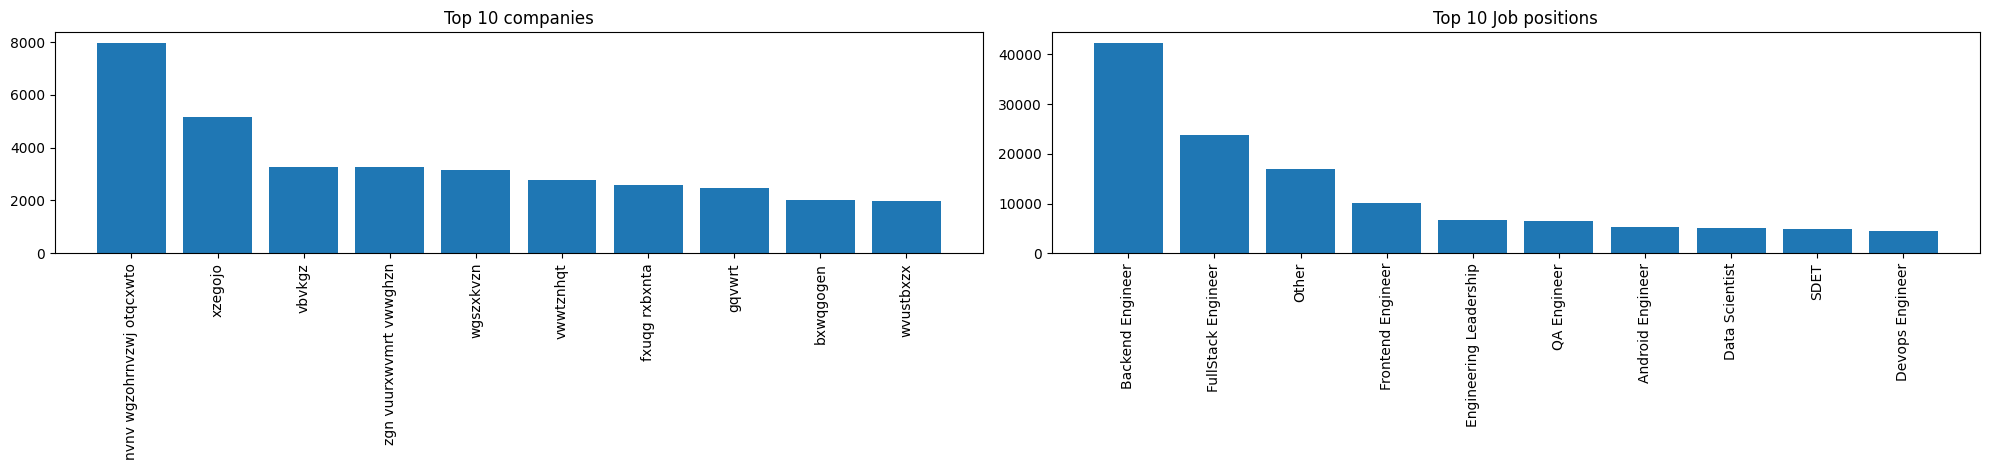

In [11]:
fig,ax=plt.subplots(nrows=1,ncols=2)
plt.rcParams.update({'font.size':10})
fig.set_figwidth(20)

dist_company=df['company_hash'].value_counts().head(10)
dist_job=df['job_position'].value_counts().head(10)

ax[0].bar(dist_company.index,dist_company)
ax[0].set_xticklabels(dist_company.index,rotation=90)
ax[0].set_title('Top 10 companies')

ax[1].bar(dist_job.index,dist_job)
ax[1].set_xticklabels(dist_job.index,rotation=90)
ax[1].set_title('Top 10 Job positions')

plt.tight_layout()

Text(0.5, 1.0, 'Frequency of occurence of emails')

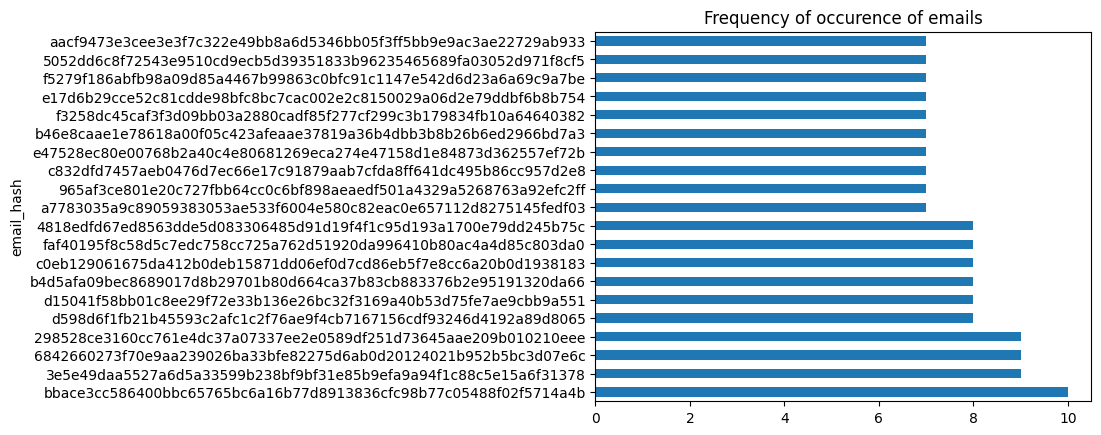

In [12]:
df['email_hash'].value_counts().head(20).plot(kind='barh')
plt.xlabel('')
plt.title('Frequency of occurence of emails')

In [13]:
df_emailcounts=pd.DataFrame(df['email_hash'].value_counts().reset_index())
df_emailcounts.rename(columns={'count':'email_count'},inplace=True)

df_companycounts=pd.DataFrame(df['company_hash'].value_counts().reset_index())
df_companycounts.rename(columns={'count':'company_count'},inplace=True)

df_jobcounts=pd.DataFrame(df['job_position'].value_counts().reset_index())
df_jobcounts.rename(columns={'count':'job_count'},inplace=True)


df=pd.merge(df,df_emailcounts)
df=pd.merge(df,df_companycounts)

df=pd.merge(df,df_jobcounts,how='left')
df['isjob_null']=df['job_position'].isnull()


In [14]:
df_imputed=df[['company_count','email_count','job_count','isjob_null','orgyear','log_ctc','ctc_updated_year']].copy()

print(df_imputed.isnull().sum())

company_count           0
email_count             0
job_count           48684
isjob_null              0
orgyear                86
log_ctc                 0
ctc_updated_year        0
dtype: int64


# Verifying the occurence of missing rows

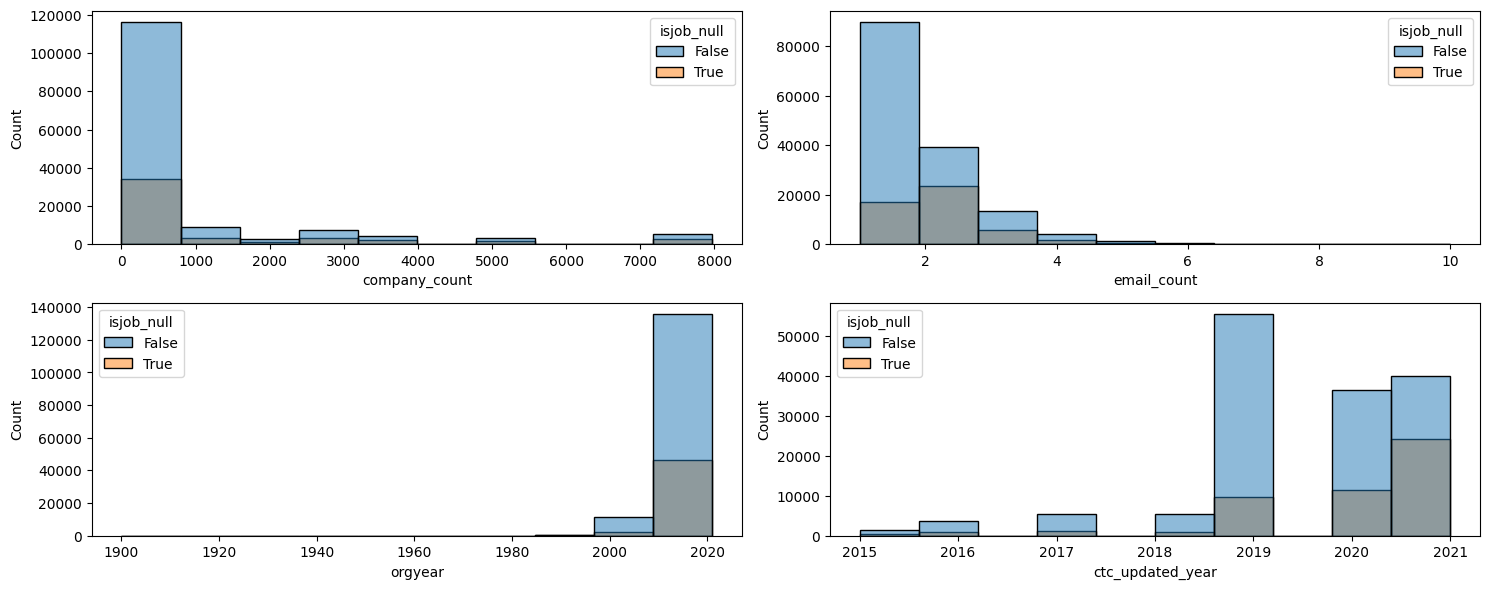

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(221)
sns.histplot(data=df_imputed,x='company_count',hue='isjob_null',bins=10)

plt.subplot(222)
sns.histplot(data=df_imputed,x='email_count',hue='isjob_null',bins=10)

plt.subplot(223)
sns.histplot(data=df_imputed,x='orgyear',hue='isjob_null',bins=10)

plt.subplot(224)
sns.histplot(data=df_imputed,x='ctc_updated_year',hue='isjob_null',bins=10)

plt.tight_layout()

Data is missing at random

# Unsure why there are duplicates of email_hash. Ideally this should be unique to each individual learner. However same value is linked with different job_profiles. For the rest of this analysis, I assume each row is a unique individual.

ToDO

1. what is the typical time for promotion for different roles within and between companies?
2. What is the CTC difference between roles in a company and between companies
3. How did the learners joining scaler change in job role over time?
  **There are corrections needed in orgyear**






# Fill missing values with the most frequent value



In [16]:
start=time.time()
np_imputed=SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(df_imputed)
print('Time = '+str(time.time()-start))
df_imputed=pd.DataFrame(np_imputed,columns=df_imputed.columns)

Time = 0.40565013885498047


In [17]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196890 entries, 0 to 196889
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_count     196890 non-null  float64
 1   email_count       196890 non-null  float64
 2   job_count         196890 non-null  float64
 3   isjob_null        196890 non-null  float64
 4   orgyear           196890 non-null  float64
 5   log_ctc           196890 non-null  float64
 6   ctc_updated_year  196890 non-null  float64
dtypes: float64(7)
memory usage: 10.5 MB


# Feature Engineering

In [18]:
df_imputed['YoE']=df_imputed['ctc_updated_year']-df_imputed['orgyear']

# df['group_YoE']=df['YoE']
# df['group_YoE']=(np.floor(df['YoE']/3))+1
# df['group_YoE'].value_counts()

df_imputed['YoE'].describe()

count    196890.000000
mean          4.771634
std           4.067384
min          -3.000000
25%           2.000000
50%           4.000000
75%           6.000000
max         119.000000
Name: YoE, dtype: float64

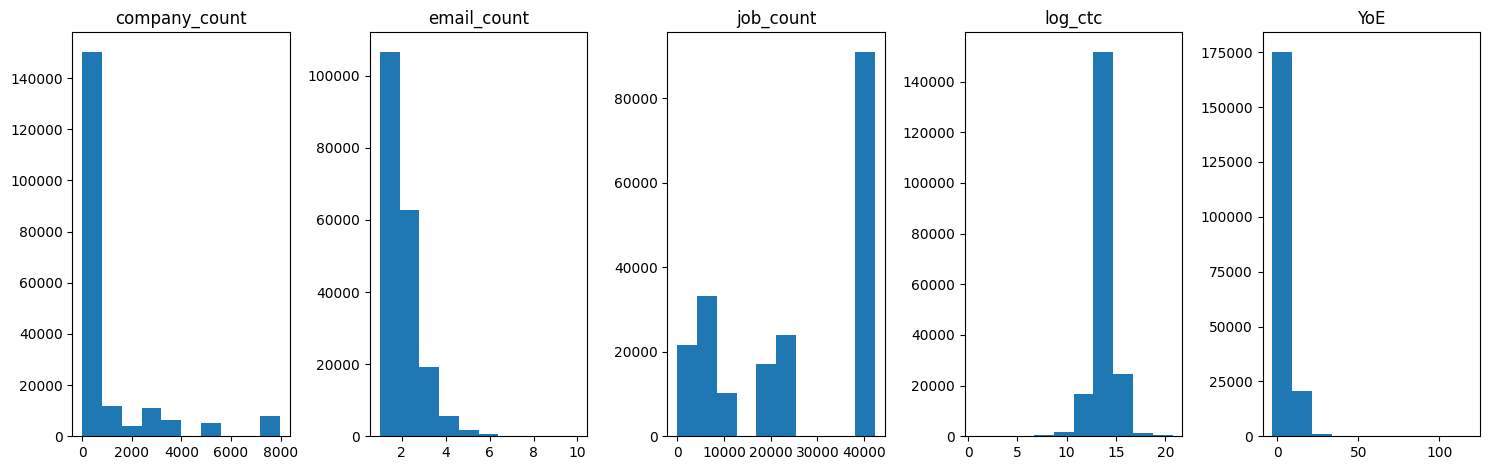

In [19]:
fig,ax=plt.subplots(nrows=1,ncols=5)
fig.set_figwidth(15)
df_imputed['log_email_count']=np.log(df['email_count'])
cols_to_plot=['company_count','email_count','job_count','log_ctc','YoE']
for finx,f in enumerate(cols_to_plot):
  ax[finx].hist(df_imputed[f],bins=10)
  ax[finx].set_title(f)

plt.tight_layout()

In [20]:
start=time.time()
df_desig=df_imputed.groupby(['company_count','job_count','YoE'])['log_ctc'].agg(['mean','median'])
print(time.time()-start)

0.0463104248046875


In [21]:
# df['company_count']=df['company_hash']
# df.loc[df['company_count']<100,'group_company']='OTHER'
# # df['group_company'].fillna('OTHER')

# df['group_job']=df['job_position']
# df.loc[df['job_count']<1000,'group_job']='OTHER'
# df['group_job'].value_counts()

# df['group_YoE']=df['YoE']
# df['group_YoE']=(np.floor(df['YoE']/3))+1
# df['group_YoE'].value_counts()

df_desig=df_imputed.groupby(['company_count','job_count','YoE'])['log_ctc'].agg(['mean','median'])
df_desig.columns=['mean_desig','median_desig']
df_desig.reset_index(inplace=True)
df_imputed=pd.merge(df_imputed,df_desig,on=['company_count','job_count','YoE'],how='left')

df_class=df_imputed.groupby(['company_count','job_count'])['log_ctc'].agg(['mean','median'])
df_class.columns=['mean_class','median_class']
df_class.reset_index(inplace=True)
df_imputed=pd.merge(df_imputed,df_class,on=['company_count','job_count'],how='left')

df_tier=df.groupby('company_count')['log_ctc'].agg(['mean','median'])
df_tier.columns=['mean_tier','median_tier']
df_imputed=pd.merge(df_imputed,df_tier,on='company_count',how='left')


# Designation is based on Company, YoE and dept
df_imputed['desig']=3
df_imputed.loc[df_imputed['log_ctc']==df_imputed['median_desig'],'desig']=2
df_imputed.loc[df_imputed['log_ctc']>df_imputed['median_desig'],'desig']=1

# Class is based on company, dept
df_imputed['class']=3
df_imputed.loc[df['log_ctc']==df_imputed['median_class'],'class']=2
df_imputed.loc[df['log_ctc']>df_imputed['median_class'],'class']=1

# Tier is based on Company
df_imputed['tier']=3
# df_imputed['tier']=np.where(df['log_ctc']<=df_imputed['median_tier'],2,1)
df_imputed.loc[df['log_ctc']==df_imputed['median_tier'],'tier']=2
df_imputed.loc[df['log_ctc']>df_imputed['median_tier'],'tier']=1



In [22]:
df_imputed.head()

,company_count,email_count,job_count,isjob_null,orgyear,log_ctc,ctc_updated_year,YoE,log_email_count,mean_desig,median_desig,mean_class,median_class,mean_tier,median_tier,desig,class,tier
0,9.0,2.0,17022.0,0.0,2016.0,13.910821,2020.0,4.0,0.693147,13.765010,13.883169,13.518460,13.399995,13.743901,13.815511,1,1,1
1,9.0,4.0,42338.0,0.0,2019.0,13.122363,2020.0,1.0,1.386294,13.268338,13.457406,13.734599,13.815511,13.743901,13.815511,3,3,3
2,9.0,1.0,5127.0,0.0,2017.0,14.346139,2020.0,3.0,0.000000,14.132482,14.151983,13.998170,13.976552,13.743901,13.815511,1,1,1
3,9.0,1.0,42338.0,0.0,2014.0,13.815511,2018.0,4.0,0.000000,13.647328,13.815511,13.734599,13.815511,13.743901,13.815511,2,2,2
4,9.0,1.0,5257.0,0.0,2017.0,13.304685,2021.0,4.0,0.000000,13.609110,13.487006,13.934751,13.914526,13.743901,13.815511,3,3,3


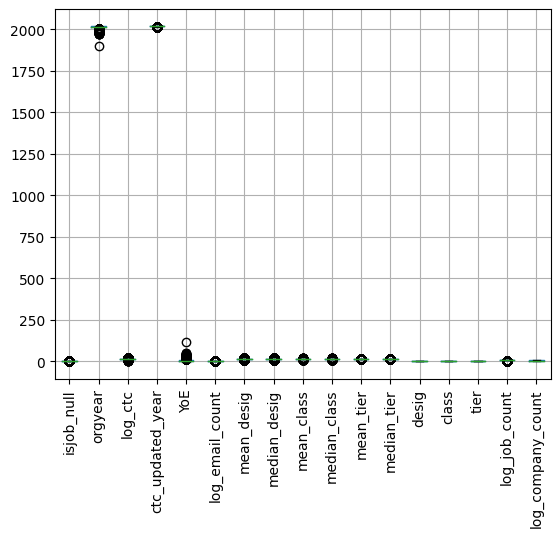

In [23]:
df_imputed['log_job_count']=np.log(df_imputed['job_count'])
df_imputed['log_company_count']=np.log(df_imputed['company_count'])

df_imputed.drop(columns=['company_count','job_count','email_count'],inplace=True)
df_imputed.boxplot()
plt.xticks(rotation=90)
plt.show()

In [24]:
df_imputed.to_pickle('/content/gdrive/My Drive/Colab Notebooks/clustering_pkl.pkl')

In [43]:
df[['tier','class','desig','YoE']]=df_imputed[['tier','class','desig','YoE']]


In [44]:
df.sort_values(['desig','class','tier','ctc'],ascending=[True,True,True,False],inplace=True)
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,log_ctc,email_count,company_count,job_count,isjob_null,tier,class,desig,YoE
171515,whmxw rgsxwo uqxcvnt rxbxnta,29a71dd13adf6d2d497571a565bb3096cf66cb46cd1ece...,2015.0,1000150000,NaN,2020.0,20.723416,1,1,NaN,True,1,1,1,5.0
23,xzegojo,4368cc6185184b811c3a4b9cef05dd1e45a682a6e94056...,2017.0,200000000,NaN,2020.0,19.113828,1,5169,NaN,True,1,1,1,3.0
66,xzegojo,5a62c4492a39b13d825bdd372b9891103252b816818b43...,2011.0,200000000,Other,2020.0,19.113828,1,5169,17022.0,False,1,1,1,9.0
514,xzegojo,4b5dcb53e770840247f358d642ecdf65891556ece4a5a2...,2015.0,200000000,NaN,2020.0,19.113828,2,5169,NaN,True,1,1,1,5.0
515,xzegojo,4b5dcb53e770840247f358d642ecdf65891556ece4a5a2...,2015.0,200000000,Other,2020.0,19.113828,2,5169,17022.0,False,1,1,1,5.0


Top 10 employees earning more than others (Tier 1)

In [27]:
df.head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,log_ctc,email_count,company_count,job_count,isjob_null,tier,class,desig
171515,whmxw rgsxwo uqxcvnt rxbxnta,29a71dd13adf6d2d497571a565bb3096cf66cb46cd1ece...,2015.0,1000150000,NaN,2020.0,20.723416,1,1,NaN,True,1,1,1
23,xzegojo,4368cc6185184b811c3a4b9cef05dd1e45a682a6e94056...,2017.0,200000000,NaN,2020.0,19.113828,1,5169,NaN,True,1,1,1
66,xzegojo,5a62c4492a39b13d825bdd372b9891103252b816818b43...,2011.0,200000000,Other,2020.0,19.113828,1,5169,17022.0,False,1,1,1
514,xzegojo,4b5dcb53e770840247f358d642ecdf65891556ece4a5a2...,2015.0,200000000,NaN,2020.0,19.113828,2,5169,NaN,True,1,1,1
515,xzegojo,4b5dcb53e770840247f358d642ecdf65891556ece4a5a2...,2015.0,200000000,Other,2020.0,19.113828,2,5169,17022.0,False,1,1,1
1351,xzegojo,d418a571a2cf09cb8cbd9eceade19381777835f58d8f98...,2018.0,200000000,NaN,2020.0,19.113828,1,5169,NaN,True,1,1,1
1370,xzegojo,9b47ee7d49f58829f8db9d133aee283529d5d64f6e6b1d...,2013.0,200000000,Other,2020.0,19.113828,1,5169,17022.0,False,1,1,1
1376,xzegojo,dcf3537dcd5f2c5cccb7207164d045d3faae7f7d27a420...,2018.0,200000000,NaN,2020.0,19.113828,1,5169,NaN,True,1,1,1
2733,xzegojo,1c0d0d8f8c85458f214991dd9855ca50cc897d34efcb14...,2016.0,200000000,Other,2020.0,19.113828,1,5169,17022.0,False,1,1,1
5242,qtrxvzwt xzegwgbb rxbxnta,f1b31a501f6b7fd6edae9e7e883bf60d2d3bff0fa37368...,2017.0,200000000,Data Analyst,2020.0,19.113828,1,419,2808.0,False,1,1,1


Top 10 employees in data science earning more than others (Class 1)

In [28]:
df[df['job_position']=='Data Scientist'].head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,log_ctc,email_count,company_count,job_count,isjob_null,tier,class,desig
79262,mqxonrtwgzt v bvyxzaqv sqghu wgbuvzj,cda8d723438e81185d2ee8c348870a4612eea974cdb2db...,2017.0,200000000,Data Scientist,2020.0,19.113828,1,42,5127.0,False,1,1,1
152139,ihvaqvnxw xzoxsyno ucn rna,bd222ea783ee372da4e0ad60fdccec0b8f37999a032025...,2015.0,200000000,Data Scientist,2019.0,19.113828,1,7,5127.0,False,1,1,1
109678,ptnovvr qtnvxr rru,72ed7ced98573f71c8f95bc8b75aac4f0677e8872c6bec...,2019.0,199800000,Data Scientist,2020.0,19.112827,1,1,5127.0,False,1,1,1
153148,wrghaotp,a1223067ab5c4ff7fcf39ed4c053057f06090a57fc05ba...,2017.0,127600000,Data Scientist,2020.0,18.664411,2,10,5127.0,False,1,1,1
99746,myvoyjvb owyggr,ee8dd42d6ea8365909147d861c7978d19f727a8075ba96...,2020.0,102500000,Data Scientist,2020.0,18.445373,1,1,5127.0,False,1,1,1
115210,xzegsvxz xzaxv uqxcvnt rxbxnta,9ddd3b9e97841f9713b1e17a264656efdf9b6fd8ba169b...,2015.0,100000000,Data Scientist,2020.0,18.420681,1,35,5127.0,False,1,1,1
140545,utqtzsg,e7722fb701c61e5cad82c39ee8bf3debe160d429b72c64...,2015.0,100000000,Data Scientist,2020.0,18.420681,1,1,5127.0,False,1,1,1
147780,xzzgcv ogrhnxgzo,6b6dd66bae787dd4dd417e1777f8ea5a057257e9019995...,2016.0,100000000,Data Scientist,2020.0,18.420681,1,10,5127.0,False,1,1,1
154721,otre tburgjta uqgetooxgzvr,5dd32aca5f483b8fa4d539778bb3f0a24073a93a80dd5a...,2010.0,100000000,Data Scientist,2020.0,18.420681,1,1,5127.0,False,1,1,1
161199,xptv,259f6168edaed6bfb1d24bebe37fe7ddc8e6419884426e...,2005.0,100000000,Data Scientist,2020.0,18.420681,1,2,5127.0,False,1,1,1


Bottom 10 employees of data science in each company earning less than their peers

In [29]:
df[(df['job_position']=='Data Scientist') & (df['class']==3)].tail(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,log_ctc,email_count,company_count,job_count,isjob_null,tier,class,desig
125887,nyt mgongz wgzohrnxzs sqghu mws,cf663c71fc96db1ea5658342e2d73050b40ca479d324de...,2016.0,8000,Data Scientist,2021.0,8.987197,1,24,5127.0,False,3,3,3
133434,tkap,4ed3d04bca6467a839f7a4f878bc15737c3c4afa9cb3a5...,2012.0,8000,Data Scientist,2017.0,8.987197,1,3,5127.0,False,3,3,3
45758,nvnv wgzohrnvzwj otqcxwto,3175d03fd4618eb293d6f5a1d13d42a0c79f68e9acaaa3...,2020.0,7500,Data Scientist,2020.0,8.922658,1,7971,5127.0,False,3,3,3
108328,wtxuvr wgqu,0dcbef1fe34438edbb39b52451378ea61ac2b84a56d919...,2017.0,7500,Data Scientist,2019.0,8.922658,4,1,5127.0,False,3,3,3
193998,dvcgq,287dd26e9357888e0ba2c7482764131f7bbcb1748a4f56...,2019.0,7250,Data Scientist,2020.0,8.888757,1,1,5127.0,False,3,3,3
149717,exznqhon ogrhnxgzo ucn rna,ab2dc9db23c3104f0b6b3dbd4cdd5bfb9e5829b8b7943d...,2017.0,7200,Data Scientist,2019.0,8.881836,3,3,5127.0,False,3,3,3
146879,ovbohzs trtwnqg btwyvzxwo,e374eea75640881206a21894f69190138c2c0535277dc1...,2017.0,7000,Data Scientist,2019.0,8.853665,3,4,5127.0,False,3,3,3
42395,srgmvrtast xzntrrxstzwt ge nyxzso,8001bc017fbe95541d23f5780c3edb988b7d9b2225e39e...,2017.0,4000,Data Scientist,2019.0,8.294050,3,31,5127.0,False,3,3,3
112089,bxyhu wgbbhzxwvnxgz,690f6fdab1ab7514a6a9325ebd6cfe910dbf12d46b6fde...,2018.0,4000,Data Scientist,2019.0,8.294050,1,12,5127.0,False,3,3,3
195422,otjch xzw,585f7e9865dcdcaad7edf10909d796ba2c5210cde3530b...,2017.0,4000,Data Scientist,2018.0,8.294050,1,1,5127.0,False,3,3,3


Bottom 10 employees (earning less than most of the employees in the company)- Tier 3

In [30]:
df[df['tier']==3]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,log_ctc,email_count,company_count,job_count,isjob_null,tier,class,desig
82869,oyvqtwyvn,4d18caf714e1640d49f6a7f27c9bf60c54d86cd298bb60...,2016.0,2900000,NaN,2019.0,14.880221,4,66,NaN,True,3,1,1
93446,sgrabvz ovwyo,99bb3aacea83c80e60ae0cd389678cb8841af591993a54...,2016.0,2670000,Backend Engineer,2019.0,14.797589,1,756,42338.0,False,3,1,1
82902,oyvqtwyvn,02794dc8f4afe0ca5eefaeb1bfd7a7b74973f7041a3520...,2017.0,2640000,Backend Engineer,2020.0,14.786289,1,66,42338.0,False,3,1,1
93517,sgrabvz ovwyo,7eb0cc70041baabd1d4027d499174262fd5ebf16af18a9...,2016.0,2630000,FullStack Engineer,2020.0,14.782494,3,756,23859.0,False,3,1,1
93518,sgrabvz ovwyo,7eb0cc70041baabd1d4027d499174262fd5ebf16af18a9...,2016.0,2630000,Backend Engineer,2020.0,14.782494,3,756,42338.0,False,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165594,uqvpqxnx voogwxvnto,8786759b95d673466e94f62f1b15e4f8c6bd7de6164074...,2020.0,24,Other,2020.0,3.178054,1,1,17022.0,False,3,3,3
194177,xm,b8a0bb340583936b5a7923947e9aec21add5ebc50cd60b...,2016.0,15,NaN,2018.0,2.708050,1,1,NaN,True,3,3,3
42358,xzntqcxtfmxn,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143...,2013.0,14,NaN,2018.0,2.639057,1,65,NaN,True,3,3,3
42360,xzntqcxtfmxn,f2b58aeed3c074652de2cfd3c0717a5d21d6fbcf342a78...,2013.0,6,NaN,2018.0,1.791759,1,65,NaN,True,3,3,3


Top 10 employees in each company having 5/6/7 years of experience earning more than their peers

In [50]:
df[(df['YoE']<=7) & (df['YoE']>=5) & (df['tier']==1)].groupby('company_hash').head(10).head(50)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,log_ctc,email_count,company_count,job_count,isjob_null,tier,class,desig,YoE
171515,whmxw rgsxwo uqxcvnt rxbxnta,29a71dd13adf6d2d497571a565bb3096cf66cb46cd1ece...,2015.0,1000150000,NaN,2020.0,20.723416,1,1,NaN,True,1,1,1,5.0
514,xzegojo,4b5dcb53e770840247f358d642ecdf65891556ece4a5a2...,2015.0,200000000,NaN,2020.0,19.113828,2,5169,NaN,True,1,1,1,5.0
515,xzegojo,4b5dcb53e770840247f358d642ecdf65891556ece4a5a2...,2015.0,200000000,Other,2020.0,19.113828,2,5169,17022.0,False,1,1,1,5.0
1370,xzegojo,9b47ee7d49f58829f8db9d133aee283529d5d64f6e6b1d...,2013.0,200000000,Other,2020.0,19.113828,1,5169,17022.0,False,1,1,1,7.0
7453,wgszxkvzn,aad581a532f319c76c6e73937572feed9867d5ee2f1093...,2014.0,200000000,Data Analyst,2020.0,19.113828,1,3144,2808.0,False,1,1,1,6.0
7904,wgszxkvzn,00eebd69d81c0bb5d4ad91392d7b994395333d98cae7f0...,2013.0,200000000,Backend Engineer,2020.0,19.113828,1,3144,42338.0,False,1,1,1,7.0
8153,wgszxkvzn,af7e865dba7de46700156df4317df109c89146217fd77e...,2015.0,200000000,Other,2020.0,19.113828,1,3144,17022.0,False,1,1,1,5.0
8545,wgszxkvzn,4b5f9d4a42d8656a5230e5fcd3666777bdcd58f0c604d1...,2012.0,200000000,NaN,2019.0,19.113828,2,3144,NaN,True,1,1,1,7.0
8546,wgszxkvzn,4b5f9d4a42d8656a5230e5fcd3666777bdcd58f0c604d1...,2012.0,200000000,Other,2019.0,19.113828,2,3144,17022.0,False,1,1,1,7.0
14497,gnytqo,e7b2b159325f77e7abd5aa938371d7f9425530b36e703f...,2013.0,200000000,Other,2020.0,19.113828,1,189,17022.0,False,1,1,1,7.0


Top 10 companies based on their max CTC offered

In [31]:
df.groupby('company_hash')['ctc'].agg('max').reset_index().sort_values('ctc',ascending=False).head(10)

,company_hash,ctc
29699,whmxw rgsxwo uqxcvnt rxbxnta,1000150000
14641,ogzv wgrrtst ge ntwyzgrgsjvzzv hzxctqoxnj,200000000
6791,fvj2gzrxzt xzntqvwnxct xzaxv ucn rna,200000000
24519,uqxzwxuvr srgmvr xzctongqo,200000000
29419,wgszxkvzn,200000000
25720,vbagwo,200000000
27285,vrnqvz,200000000
9451,ktzovq ntwyzgrgsxto,200000000
18834,qmo,200000000
22706,tihxnvo obvrr exzvzwt mvzp,200000000


Top 2 positions in every company (based on their max CTC offered)

In [41]:
ctc_by_company_and_dept=df.groupby(['company_hash','job_position'])['ctc'].agg('max').reset_index()
ctc_by_company_and_dept.groupby('company_hash').tail(2).head(50)

,company_hash,job_position,ctc
0,0,Other,100000
1,0000,Other,300000
2,01 ojztqsj,Android Engineer,270000
3,01 ojztqsj,Frontend Engineer,830000
4,05mz exzytvrny uqxcvnt rxbxnta,Backend Engineer,1100000
5,1 axsxnvro,Backend Engineer,350000
6,1 jtvq,Backend Engineer,1700000
7,10,Backend Engineer,450000
8,10 axsxnvr ahmvx rgzagz,Android Engineer,1300000
9,1000uqgltwn,Frontend Engineer,600000


# Dimensionality reduction and Clustering

In [52]:
df=pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/clustering_pkl.pkl')

X=df.copy()


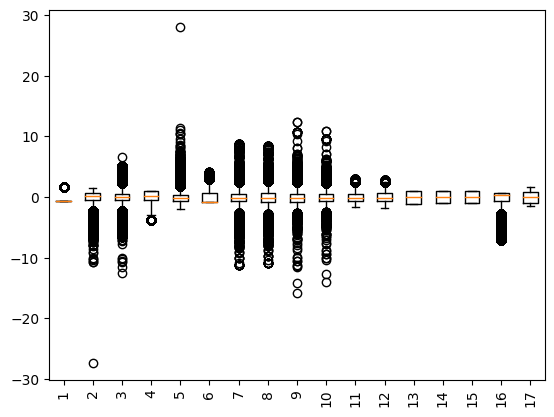

In [53]:
stdsc=StandardScaler()
X_scaled=stdsc.fit_transform(X)

# X_scaled

plt.boxplot(X_scaled)
plt.xticks(rotation=90)
plt.show()

In [54]:
print(X_scaled.shape)

# np.random.seed(0)
# rand_rows=np.random.randint(148144,size=30000)
# X_sm=X_scaled[rand_rows,:]
# print(X_sm.shape)

(196890, 17)
(30000, 17)


In [140]:
pcamodel=PCA(n_components=2).fit(X_scaled)
pcacomponents=pcamodel.transform(X_scaled)

In [141]:
pcamodel.explained_variance_ratio_
# pca.shape

array([0.32795273, 0.16955132])

Text(0.5, 1.0, 'PCA using all the data rows')

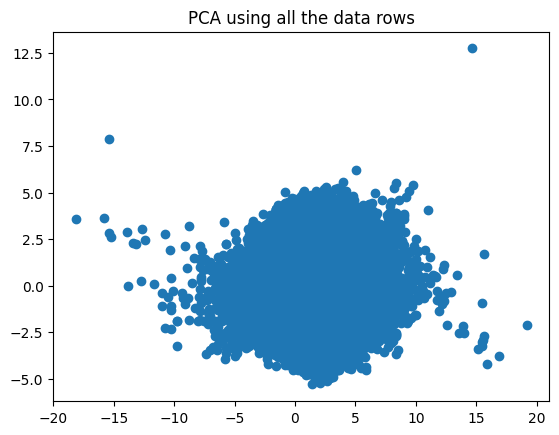

In [142]:
plt.scatter(pcacomponents[:,0],pcacomponents[:,1])
plt.title('PCA using all the data rows')

In [143]:
# start=time.time()
# umap_components=umap.UMAP().fit_transform(X_scaled)
# print(['time taken = '+str(time.time()-start)])

# plt.scatter(umap_components[:,0],umap_components[:,1])
# plt.title('UMAP using full data')

In [144]:
# np.save('/content/gdrive/My Drive/Colab Notebooks/UMAP_Fulldata',umap_components)

Text(0.5, 1.0, 'UMAP using full data')

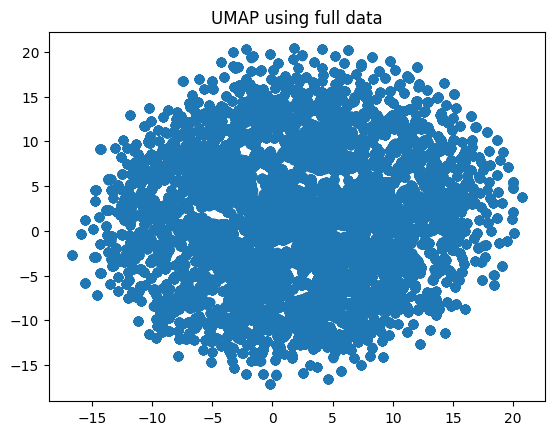

In [145]:
umap_components=np.load('/content/gdrive/My Drive/Colab Notebooks/UMAP_Fulldata.npy')

plt.scatter(umap_components[:,0],umap_components[:,1])
plt.title('UMAP using full data')

# Clustering

In [146]:
KMeansobj=[KMeans(n_clusters=i).fit(X_scaled) for i in range(1,10)]

WCSS=[Kobj.inertia_ for Kobj in KMeansobj]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Beyond 5 clusters gain in WCSS is low


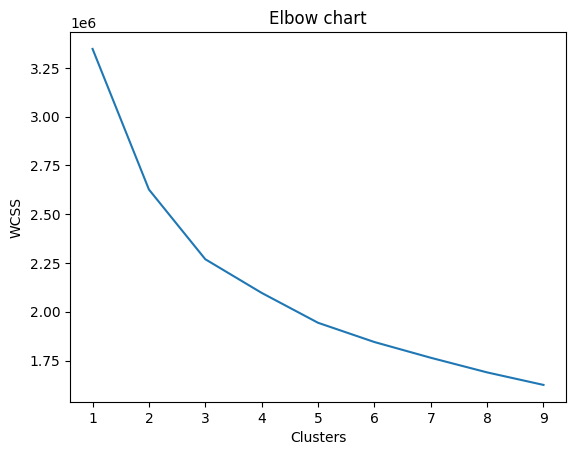

In [147]:
plt.plot(range(1,10),WCSS)
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.title('Elbow chart')
print('Beyond 5 clusters gain in WCSS is low')

Between 4 and 5 clusters, 5 clusters has higher Silhouette score. Hence 5 clusters is optimal


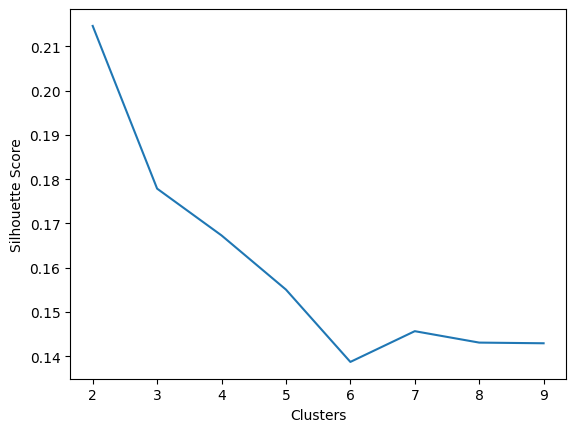

In [148]:
sil_score=[silhouette_score(X_sm,kmeansobj.predict(X_sm)) for kmeansobj in KMeansobj[1:]]

plt.plot(range(2,10),sil_score)
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
print('Between 4 and 5 clusters, 5 clusters has higher Silhouette score. Hence 5 clusters is optimal')

<Axes: xlabel='umap_component_1', ylabel='umap_component_2'>

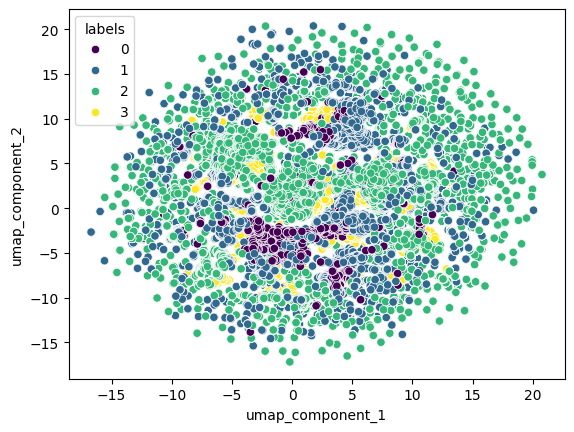

In [149]:

Kmeans_with_umap=pd.DataFrame(umap_components,columns=['umap_component_1','umap_component_2'])
Kmeans_with_umap['labels']=KMeansobj[3].labels_
Kmeans_with_umap.head()

sns.scatterplot(data=Kmeans_with_umap,x='umap_component_1',y='umap_component_2',hue='labels',palette='viridis')

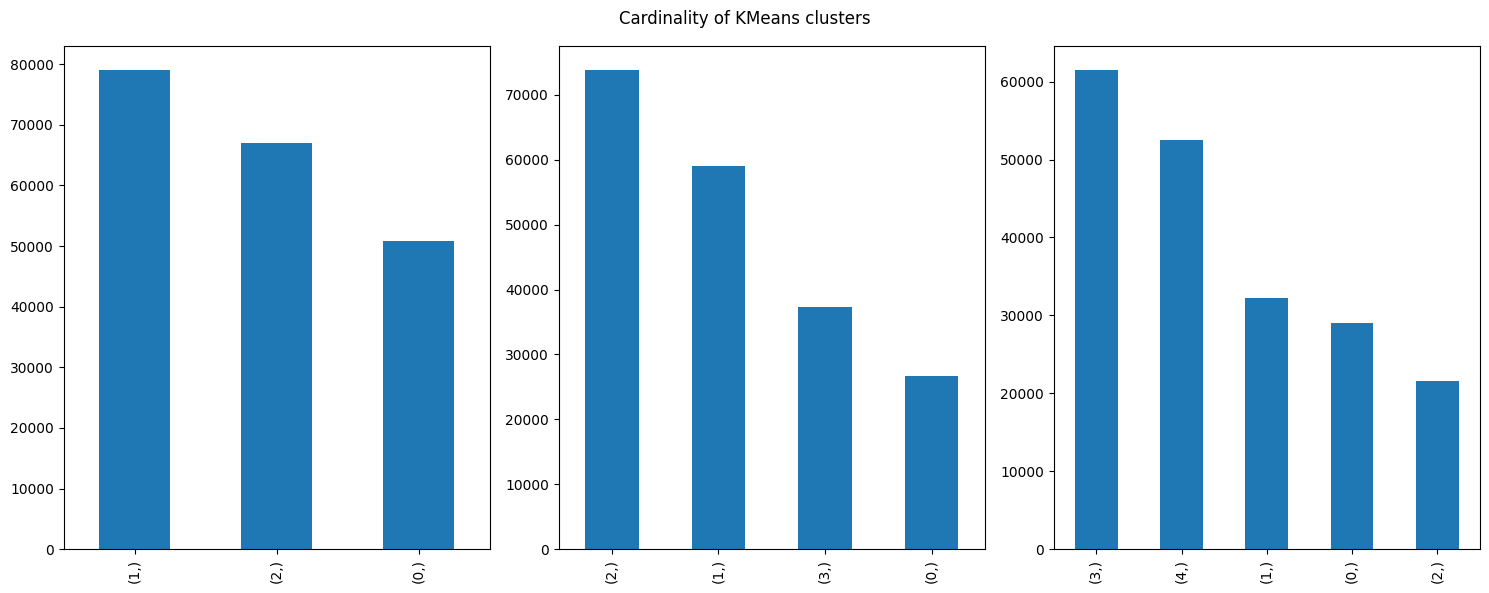

In [150]:
plt.figure(figsize=(15,6))
plt.subplot(131)
pd.DataFrame(KMeansobj[2].labels_).value_counts().plot(kind='bar')
plt.xlabel('')

plt.subplot(132)
pd.DataFrame(KMeansobj[3].labels_).value_counts().plot(kind='bar')
plt.xlabel('')

plt.subplot(133)
pd.DataFrame(KMeansobj[4].labels_).value_counts().plot(kind='bar')
plt.xlabel('')
plt.suptitle('Cardinality of KMeans clusters')

plt.tight_layout()

<Axes: xlabel='pca_component_1', ylabel='pca_component_2'>

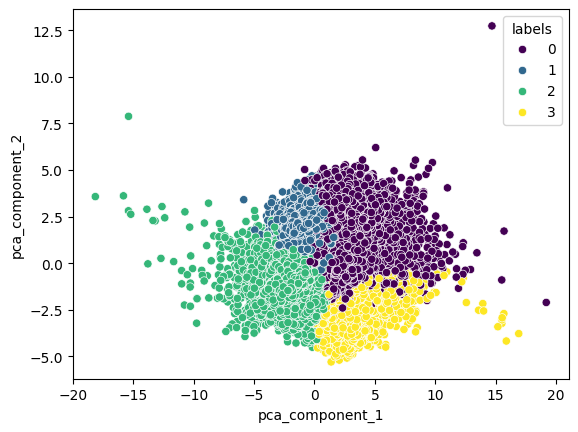

In [151]:
Kmeans_with_pca=pd.DataFrame(pcacomponents,columns=['pca_component_1','pca_component_2'])
Kmeans_with_pca['labels']=KMeansobj[3].labels_
Kmeans_with_pca.head()

sns.scatterplot(data=Kmeans_with_pca,x='pca_component_1',y='pca_component_2',hue='labels',palette='viridis')

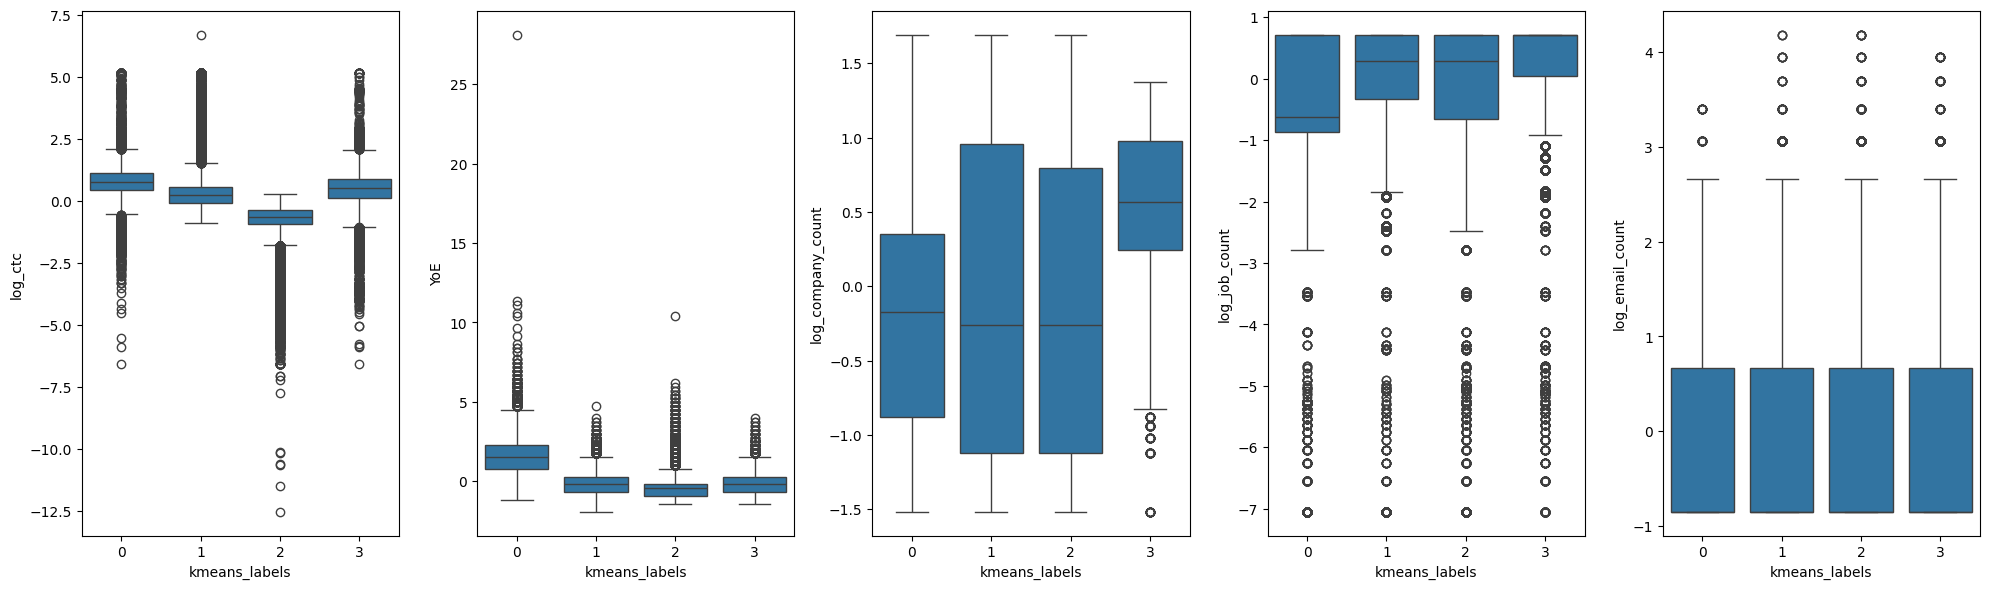

In [152]:
df_scaled=pd.DataFrame(X_scaled,columns=X.columns)
df_scaled['kmeans_labels']=KMeansobj[3].labels_

plt.figure(figsize=(20,6))

plt.subplot(1,5,1)
sns.boxplot(data=df_scaled,x='kmeans_labels',y='log_ctc')

plt.subplot(1,5,2)
sns.boxplot(data=df_scaled,x='kmeans_labels',y='YoE')

plt.subplot(1,5,3)
sns.boxplot(data=df_scaled,x='kmeans_labels',y='log_company_count')

plt.subplot(1,5,4)
sns.boxplot(data=df_scaled,x='kmeans_labels',y='log_job_count')

plt.subplot(1,5,5)
sns.boxplot(data=df_scaled,x='kmeans_labels',y='log_email_count')

plt.tight_layout()
plt.show()

# DBSCAN

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf

In [153]:
# eps_vals=np.arange(1.6,2,0.1)

# start=time.time()
# dbscan_objs=[DBSCAN(eps=eps_val,min_samples=34).fit(X_scaled) for eps_val in eps_vals]
# print(time.time()-start)

# dbscan_numlabels=[np.max(dbscan_obj.labels_) for dbscan_obj in dbscan_objs]
# dbscan_numlabels=[np.max(dbscan_obj.labels_) for dbscan_obj in dbscan_objs]
# plt.plot(eps_vals,dbscan_numlabels)
# plt.ylabel('Number of clusters')
# plt.xlabel('eps')
# plt.show()

In [134]:
start=time.time()
dbscan=DBSCAN(eps=1.8,min_samples=34).fit(X_scaled)
print('time = '+str(time.time()-start))

print(pd.DataFrame(dbscan.labels_).value_counts())

time = 158.65998578071594
 0    140988
 1     47991
-1      7720
 4        69
 5        53
 2        35
 3        34
Name: count, dtype: int64


In [154]:
df_scaled['dbscan_labels']=dbscan.labels_
df_scaled.head()

,isjob_null,orgyear,log_ctc,ctc_updated_year,YoE,log_email_count,mean_desig,median_desig,mean_class,median_class,mean_tier,median_tier,desig,class,tier,log_job_count,log_company_count,kmeans_labels,dbscan_labels
0,-0.573139,0.256580,0.155931,0.245206,-0.189713,0.664273,0.027729,0.180962,-0.528757,-0.753363,-0.01223,0.146123,-1.085839,-1.024723,-1.013171,0.045075,-0.731874,1,0
1,-0.573139,0.969009,-0.599876,0.245206,-0.927290,2.177841,-0.789320,-0.490382,-0.031203,0.096528,-0.01223,0.146123,1.092455,1.022727,1.014521,0.708473,-0.731874,2,0
2,-0.573139,0.494056,0.573223,0.245206,-0.435572,-0.849295,0.632240,0.604827,0.575542,0.425921,-0.01223,0.146123,-1.085839,-1.024723,-1.013171,-0.828593,-0.731874,1,0
3,-0.573139,-0.218372,0.064568,-1.342855,-0.189713,-0.849295,-0.165862,0.074277,-0.031203,0.096528,-0.01223,0.146123,0.003308,-0.000998,0.000675,0.708473,-0.731874,1,0
4,-0.573139,0.494056,-0.425104,1.039237,-0.189713,-0.849295,-0.228733,-0.443708,0.429551,0.299053,-0.01223,0.146123,1.092455,1.022727,1.014521,-0.810362,-0.731874,2,0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


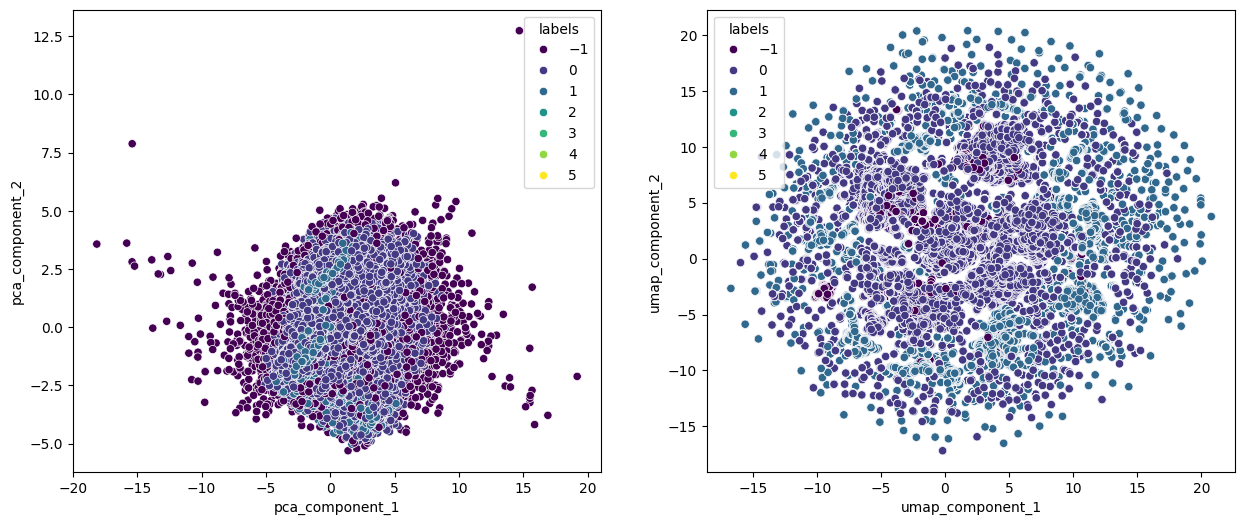

In [155]:
dbscan_with_pca=pd.DataFrame(pcacomponents,columns=['pca_component_1','pca_component_2'])
dbscan_with_pca['labels']=dbscan.labels_

dbscan_with_umap=pd.DataFrame(umap_components,columns=['umap_component_1','umap_component_2'])
dbscan_with_umap['labels']=dbscan.labels_

plt.figure(figsize=(15,6))
plt.subplot(121)
sns.scatterplot(data=dbscan_with_pca,x='pca_component_1',y='pca_component_2',hue='labels',palette='viridis')

plt.subplot(122)
sns.scatterplot(data=dbscan_with_umap,x='umap_component_1',y='umap_component_2',hue='labels',palette='viridis')
plt.show()

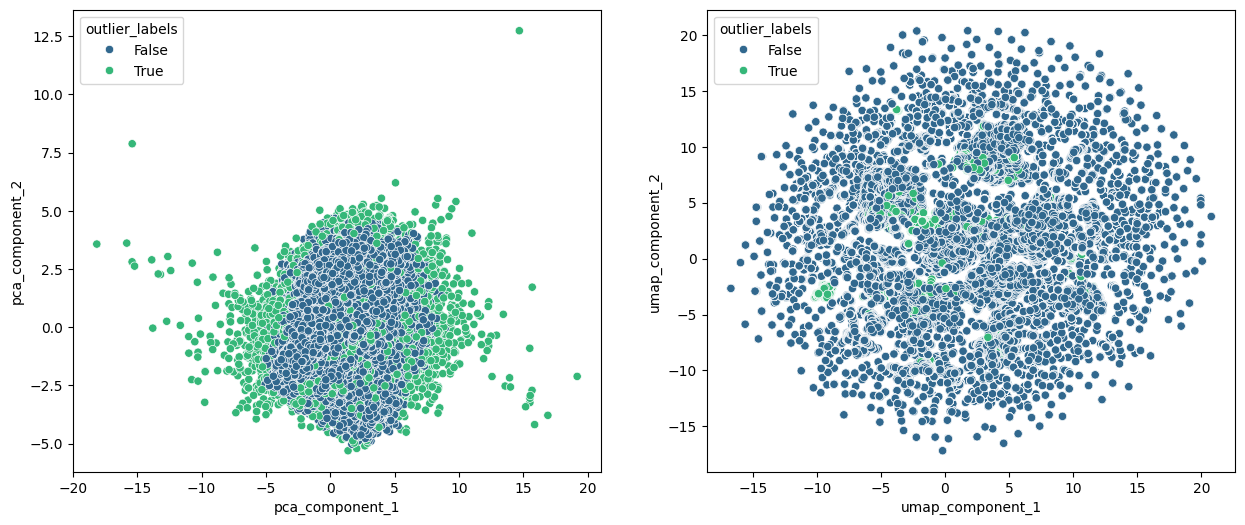

In [156]:
dbscan_with_pca['outlier_labels']=dbscan_with_pca['labels']==-1

dbscan_with_umap['outlier_labels']=dbscan_with_umap['labels']==-1

plt.figure(figsize=(15,6))
plt.subplot(121)
sns.scatterplot(data=dbscan_with_pca,x='pca_component_1',y='pca_component_2',hue='outlier_labels',palette='viridis')

plt.subplot(122)
sns.scatterplot(data=dbscan_with_umap,x='umap_component_1',y='umap_component_2',hue='outlier_labels',palette='viridis')
plt.show()

In [ ]:
print(dbscan_with_pca['outlier_labels'].value_counts())
print(dbscan_with_umap['outlier_labels'].value_counts())

outlier_labels
False    189196
True       7694
Name: count, dtype: int64
outlier_labels
False    189196
True       7694
Name: count, dtype: int64


# Insights from the clustering

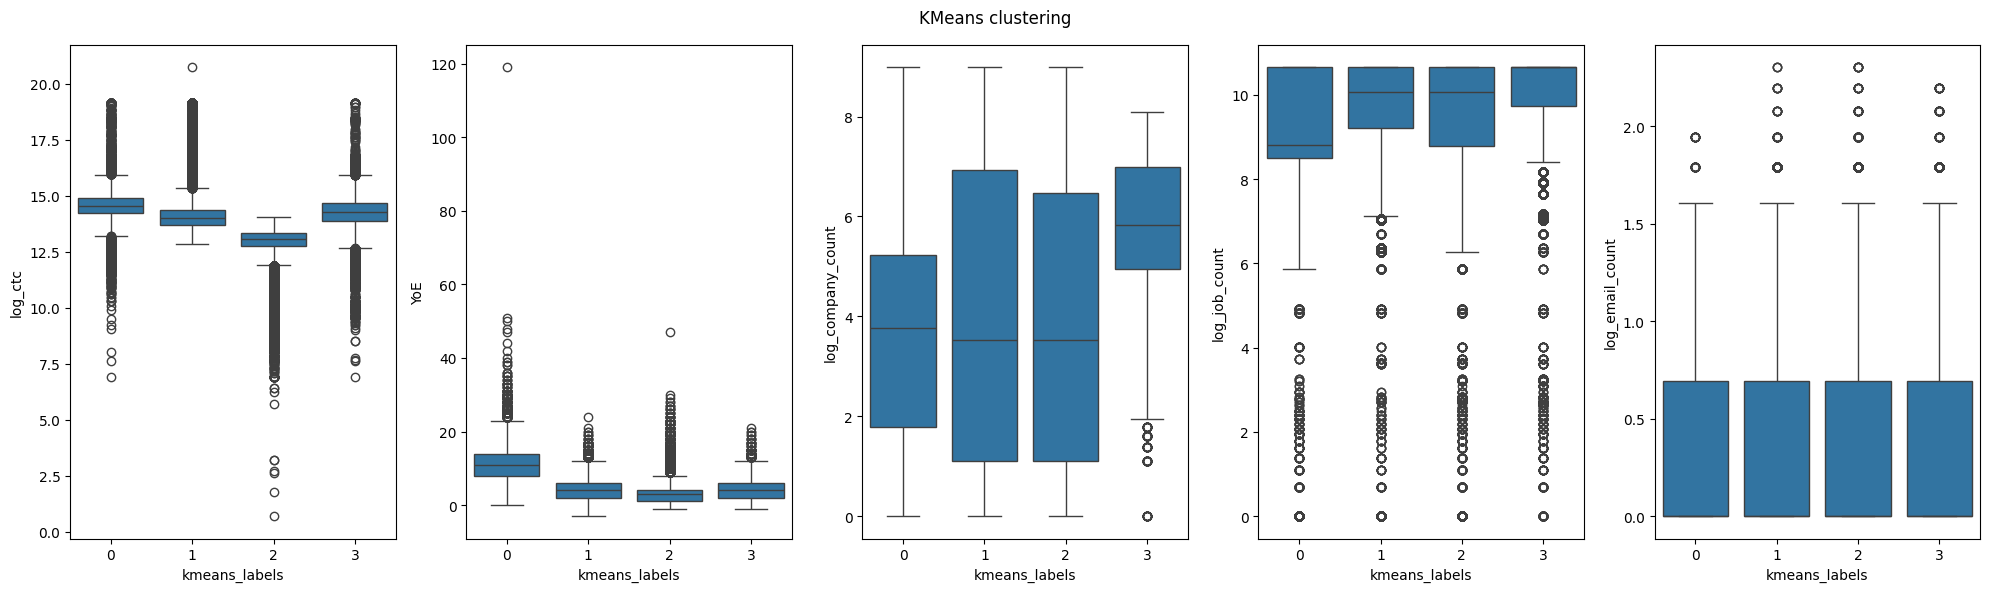

In [157]:
df['kmeans_labels']=KMeansobj[3].labels_

plt.figure(figsize=(20,6))

plt.subplot(1,5,1)
sns.boxplot(data=df,x='kmeans_labels',y='log_ctc')

plt.subplot(1,5,2)
sns.boxplot(data=df,x='kmeans_labels',y='YoE')

plt.subplot(1,5,3)
sns.boxplot(data=df,x='kmeans_labels',y='log_company_count')

plt.subplot(1,5,4)
sns.boxplot(data=df,x='kmeans_labels',y='log_job_count')

plt.subplot(1,5,5)
sns.boxplot(data=df,x='kmeans_labels',y='log_email_count')

plt.suptitle('KMeans clustering')
plt.tight_layout()
plt.show()


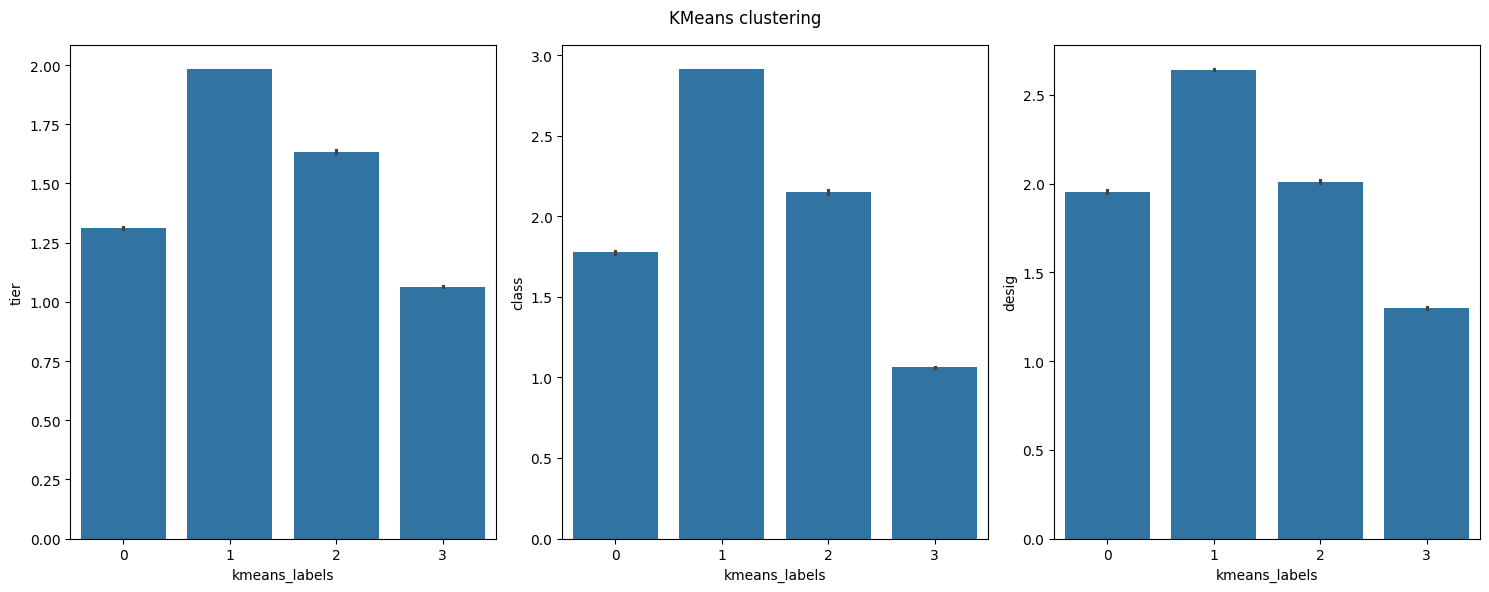

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(131)
sns.barplot(data=df,x='kmeans_labels',y='tier')

plt.subplot(132)
sns.barplot(data=df,x='kmeans_labels',y='class')

plt.subplot(133)
sns.barplot(data=df,x='kmeans_labels',y='desig')
plt.suptitle('KMeans clustering')

plt.tight_layout()

In [59]:
df.head()

,isjob_null,orgyear,log_ctc,ctc_updated_year,YoE,log_email_count,mean_desig,median_desig,mean_class,median_class,mean_tier,median_tier,desig,class,tier,log_job_count,log_company_count
0,0.0,2016.0,13.910821,2020.0,4.0,0.693147,13.765010,13.883169,13.518460,13.399995,13.743901,13.815511,1,1,1,9.742262,2.197225
1,0.0,2019.0,13.122363,2020.0,1.0,1.386294,13.268338,13.457406,13.734599,13.815511,13.743901,13.815511,3,3,3,10.653440,2.197225
2,0.0,2017.0,14.346139,2020.0,3.0,0.000000,14.132482,14.151983,13.998170,13.976552,13.743901,13.815511,1,1,1,8.542276,2.197225
3,0.0,2014.0,13.815511,2018.0,4.0,0.000000,13.647328,13.815511,13.734599,13.815511,13.743901,13.815511,2,2,2,10.653440,2.197225
4,0.0,2017.0,13.304685,2021.0,4.0,0.000000,13.609110,13.487006,13.934751,13.914526,13.743901,13.815511,3,3,3,8.567316,2.197225


10.150218725204468


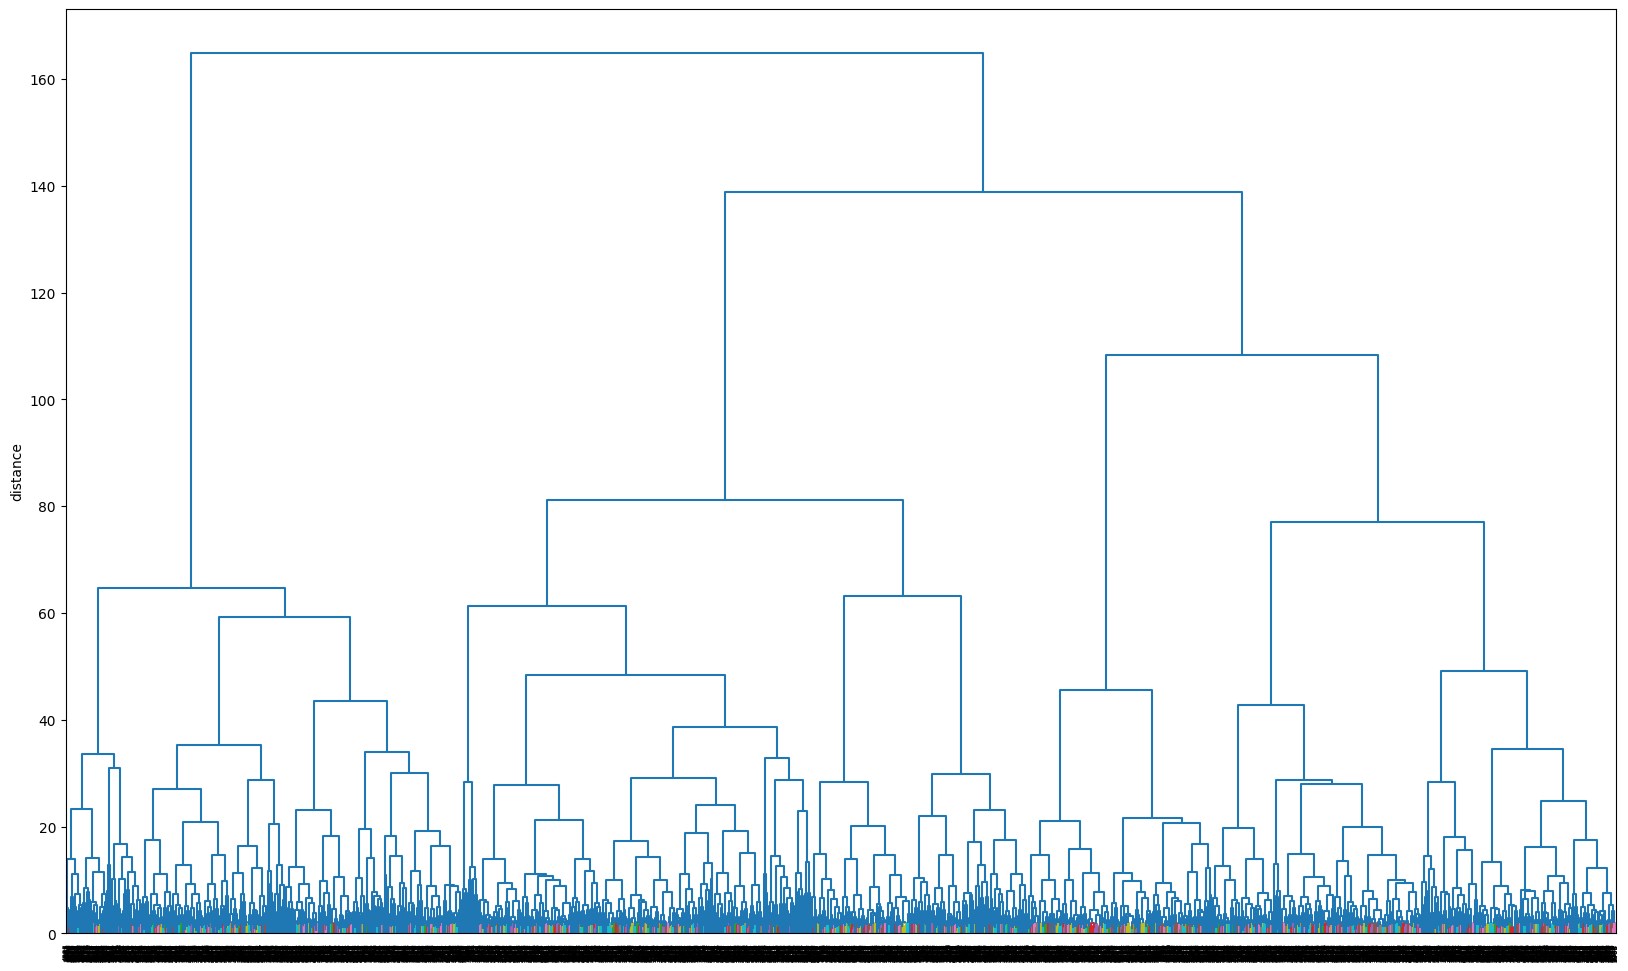

In [62]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch

np.random.seed(0)
rand_rows=np.random.randint(148144,size=5000)
X_sm=X_scaled[rand_rows,:]

start=time.time()

# Refer https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
dgram = sch.linkage(X_sm, method='ward') #linkage = ward

fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(dgram, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')
print(time.time()-start)